In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.preprocessing import Binarizer

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score,precision_score,roc_auc_score
from sklearn.metrics import precision_recall_curve,roc_curve,confusion_matrix , auc

from sklearn.inspection import permutation_importance
import eli5
from eli5.sklearn import PermutationImportance

from sklearn.pipeline import Pipeline,make_pipeline

In [1]:
def model_basic(x_train, y_train, x_test, y_test): 
    models = [
         LogisticRegression(C=0.1,max_iter=170,penalty='l2',solver='lbfgs',random_state=200),
         LinearDiscriminantAnalysis(priors=[0.9669206094627105, 0.0330793905372895], solver='lsqr',shrinkage= 'auto'),
         GaussianNB(priors=[0.9669206094627105, 0.0330793905372895]),
         RandomForestClassifier(random_state=1,class_weight=None, max_depth=8, min_samples_leaf= 10, min_samples_split= 4, n_estimators= 10),
         XGBClassifier(random_state=1, colsample_bytree= 1, gamma= 3, learning_rate= 0.01, max_depth=4, min_child_weight= 1, n_estimators= 100, subsample= 0.6)
    ]

    rdict={'model':[],'acc_train':[], 'auc_train':[], 'acc_test':[],'precision':[],'recall':[],'f1_score':[], 'AUC_test':[]}


    for clf in models:
        clf = clf.fit(x_train, y_train)
    #1열:Train
        y_hat = clf.predict(x_train)
        y_proba = clf.predict_proba(x_train)[:,1].reshape(-1,1)
        results_train  = (round(accuracy_score(y_train,y_hat),2),round(roc_auc_score(y_train,y_proba),2))
    #2열:Test
        y_hat = clf.predict(x_test)
        y_proba = clf.predict_proba(x_test)[:,1].reshape(-1,1)
        results = (round(accuracy_score(y_test,y_hat),2),
                        round(precision_score(y_test,y_hat),2),
                        round(recall_score(y_test,y_hat),2),
                        round(f1_score(y_test,y_hat),2),
                        round(roc_auc_score(y_test,y_proba),2))

        rdict['model'].append(clf); 
        rdict['acc_train'].append(results_train[0])
        rdict['auc_train'].append(results_train[1])
        
        rdict['acc_test'].append(results[0])
        rdict['precision'].append(results[1])
        rdict['recall'].append(results[2])
        rdict['f1_score'].append(results[3])
        rdict['AUC_test'].append(results[4])   

        confusion = confusion_matrix(y_test, y_hat)

        print(confusion)

    rdf_final = pd.DataFrame(data=rdict)
    return rdf_final

In [3]:
def eval(test,pred):
    acc = accuracy_score(test,pred)
    f1 = f1_score(test,pred)
    precision = precision_score(test,pred)
    recall = recall_score(test,pred)
    print('##############\n',confusion_matrix(test,pred),
    "############\n",f'acc_score: {acc}\n f1_score: {f1} \n precision: {precision} \n recall: {recall}')

## 임계값 =[] 리스트생성 후 for 구문
def get_eval_by_threshold(y_test , pred_proba_c1, thresholds=[0.5,0.52,0.54,0.56,0.58,0.6,0.62]):
    # thresholds list객체내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1) 
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:',custom_threshold)
        eval(y_test , custom_predict)


def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    

## roc curve_plot    
def roc_curve_plot(y_test,pred_proba):
    fprs, tprs, thresholds = roc_curve(y_test,pred_proba) ## 입력시 1레이블 컬럼만 추출
    
    # Roc curve를 plot 곡선으로 기름
    plt.plot(fprs,tprs,label='ROC')
    ## 가운데 대각선 직선을 그림
    plt.plot([0,1],[0,1],"k--",label="ramdom")
    
    ## fpr x축을 scale을 0.1단위로 변경 x,y축 명 설정
    start,end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR(1-sensitivity)')
    plt.ylabel('TPR(recall)')
    plt.legend()
    plt.show()

In [4]:
def plot_pr_auc_curve(y_true, y_pred_proba):
    # Calculate precision, recall and threshold values
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    # Calculate PR-AUC score
    pr_auc = auc(recall, precision)
    # Plot the PR-AUC curve
    plt.plot(recall, precision, label=f'PR-AUC = {pr_auc:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR-AUC Curve')
    plt.legend()
    plt.show()

def get_pr_auc_score(y_true, y_pred_proba):
    # Calculate precision, recall and threshold values
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    # Calculate PR-AUC score
    pr_auc = auc(recall, precision)
    return pr_auc

In [5]:
## 스케일링 처리 안한 데이터 
train = pd.read_csv('./datasets/통계검증완료/코스닥_원본_train.csv',index_col=0)
test =  pd.read_csv('./datasets/통계검증완료/코스닥_원본_test.csv',index_col=0)


train = train.sort_values(by=['회계년도'],ascending=True)
test = test.sort_values(by=['회계년도'],ascending=True)

id_col = ['회사명', '거래소코드', '회계년도', '산업군','target_3']

최종_col_3 = ['abs(영업현금흐름-당기순이익)/매출액', '누적수익성비율', 'WW지수','금융비용부담률', 'TMD', '순운전자본비율']
train_x = train[최종_col_3]
train_y = train["target_3"]

test_x = test[최종_col_3]
test_y = test["target_3"]

C:\Users\msi\AppData\Local\Temp\ipykernel_22132\659727165.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


<AxesSubplot:title={'center':'Correlation of Features'}>

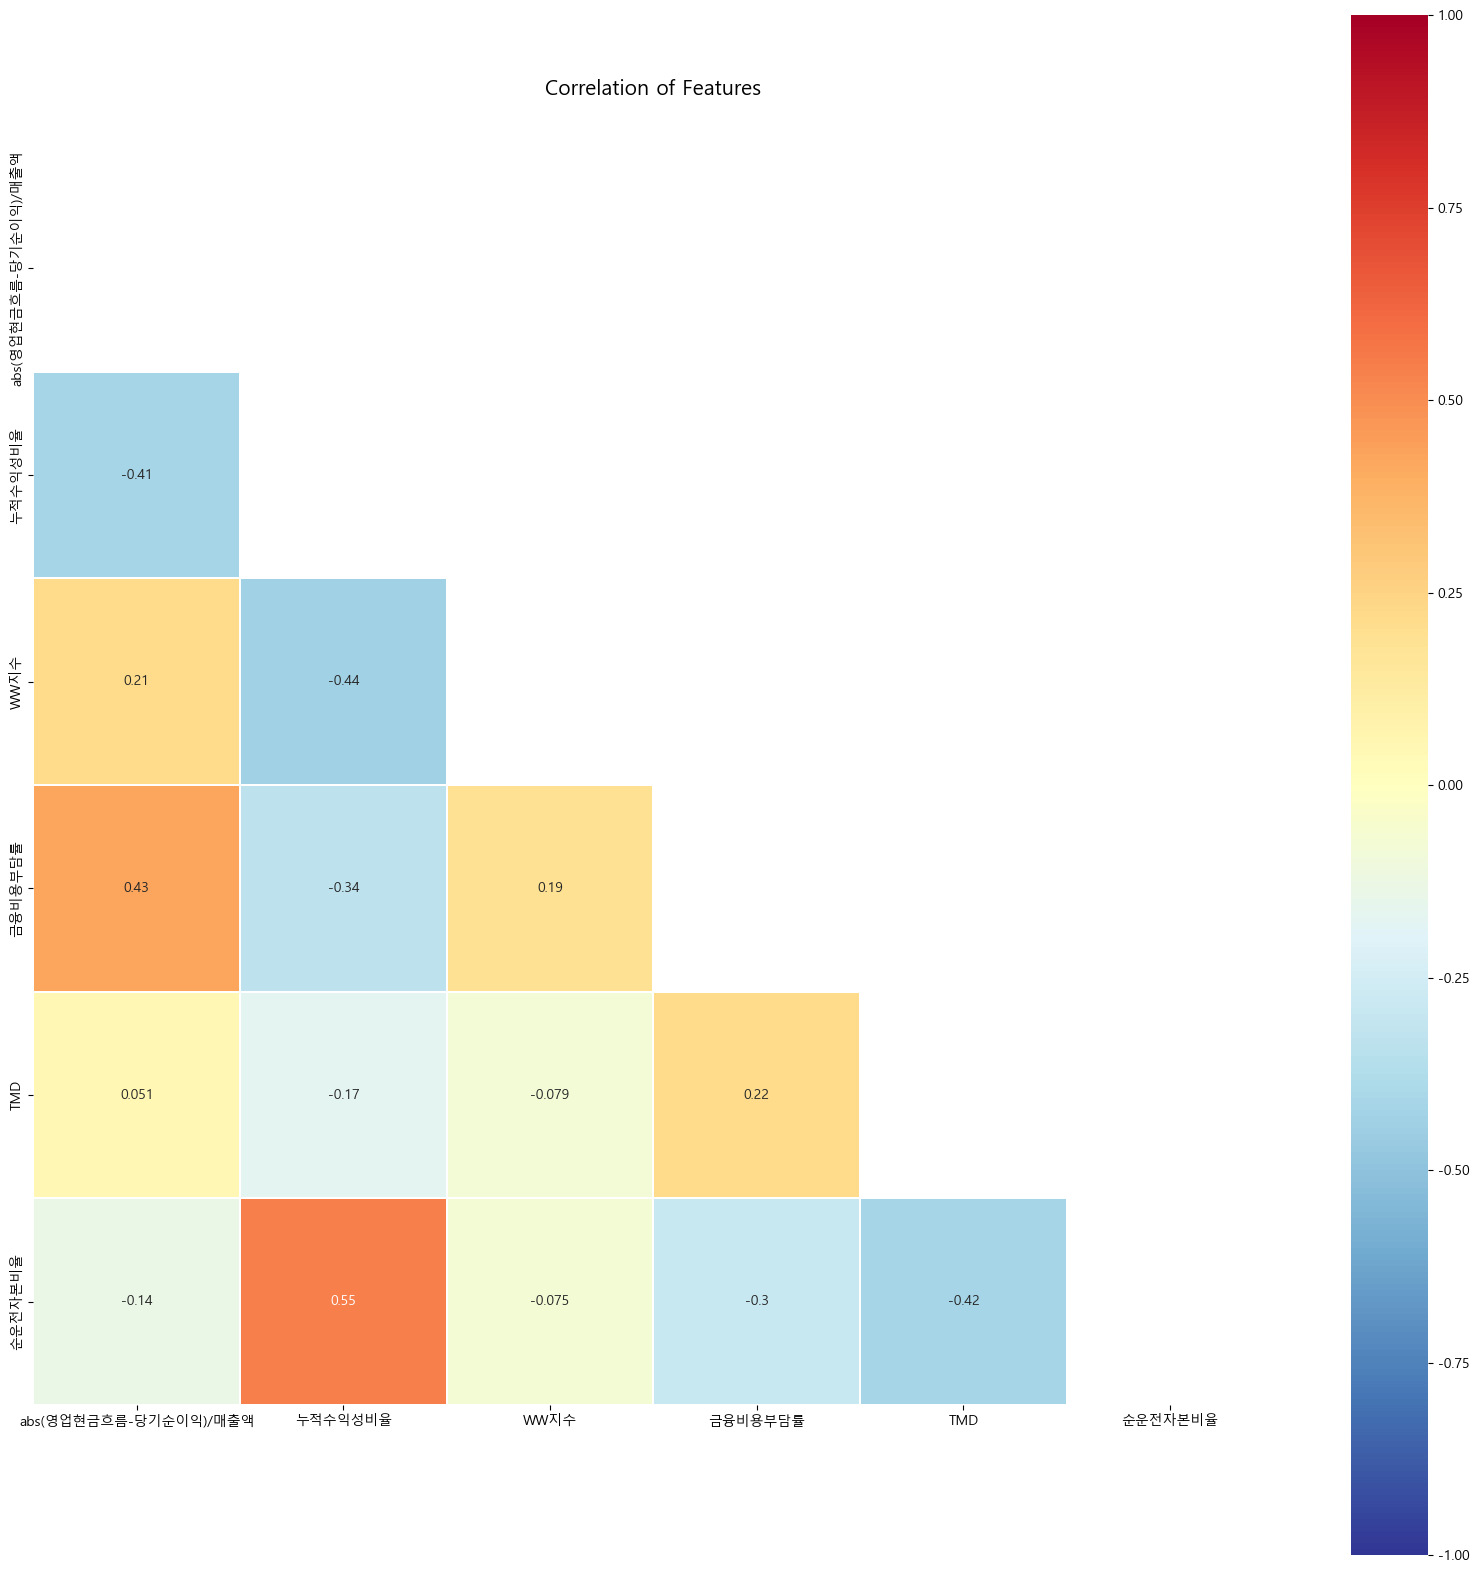

In [11]:
colormap = plt.cm.hot

corr = train_x.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.figure(figsize=(20, 20))
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family="Malgun Gothic")
plt.title("Correlation of Features", y=1.05, size=15)
sns.heatmap(corr,  linewidths=0.1, vmax=1.0, vmin=-1.0, square=True,mask=mask,
            cmap='RdYlBu_r', linecolor="white", annot=True, annot_kws={'size': 10})

## random과grid차이
- random은 넓은 범위에 하이퍼파라미터를 찾을때 효율적 랜덤한 조합으로 학습시키기때문 - 그러나 어떤조합은 적합시키지 않을수있음 그러므로 반복횟수를 적절하게 조절하는것이필요
- grid는 모든경우에 수를 적합시킴 그러므로 조합의 수가 많아진다면 시간이 오래걸리기때문에 오히려 random으로했을때 시간적으로 효율적일 수 있음
------------------------------------

## GLM
---


In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf


# 로지스틱 회귀 모델을 적합합니다.
model = sm.GLM(train_y, sm.add_constant(train_x), family=sm.families.Binomial()).fit()

# 결과를 출력합니다.
model.summary()

## LOGISTIC

In [13]:
c = train_y.value_counts(property)
c

0    0.963415
1    0.036585
Name: target_3, dtype: float64

In [15]:
lr=LogisticRegression(random_state=1,n_jobs=-1,)
param = {
    'solver' :['lbfgs', 'liblinear','sag', 'saga','newton-cg', 'newton-cholesky'],
    'C': [0.001,0.005,0.01,0.1,0.5, 1,5,7],
    'penalty': ['l2','l1','elasticnet'],
    'max_iter':[100,130,150,170,180,200],
    'class_weight':[None,'balanced'],
    'l1_ratio':[0.5,0.6,0.4,0.1]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

grid_lr = GridSearchCV(lr,n_jobs=-1,scoring='f1',cv=cv,param_grid=param,refit=True)
grid_lr.fit(train_x,train_y)

scores_df = pd.DataFrame(grid_lr.cv_results_)
scores_df[scores_df['rank_test_score']==1]

c:\Users\msi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
17280 fits failed out of a total of 34560.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1920 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\msi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\msi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\msi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 54, in _check_solver
    raise ValueError(
Value

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_l1_ratio,param_max_iter,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5184,0.126851,0.033347,0.005386,4.880335e-04,5,None,0.5,100,l2,lbfgs,"{'C': 5, 'class_weight': None, 'l1_ratio': 0.5...",0.701754,0.653846,0.666667,0.521739,0.68,0.644801,0.06354,1
5188,0.151772,0.027186,0.005784,7.462511e-04,5,None,0.5,100,l2,newton-cg,"{'C': 5, 'class_weight': None, 'l1_ratio': 0.5...",0.701754,0.653846,0.666667,0.521739,0.68,0.644801,0.06354,1
5189,0.084368,0.037620,0.005784,7.462637e-04,5,None,0.5,100,l2,newton-cholesky,"{'C': 5, 'class_weight': None, 'l1_ratio': 0.5...",0.701754,0.653846,0.666667,0.521739,0.68,0.644801,0.06354,1
5202,0.086167,0.007362,0.005585,7.977367e-04,5,None,0.5,130,l2,lbfgs,"{'C': 5, 'class_weight': None, 'l1_ratio': 0.5...",0.701754,0.653846,0.666667,0.521739,0.68,0.644801,0.06354,1
5206,0.171129,0.060182,0.005784,3.993273e-04,5,None,0.5,130,l2,newton-cg,"{'C': 5, 'class_weight': None, 'l1_ratio': 0.5...",0.701754,0.653846,0.666667,0.521739,0.68,0.644801,0.06354,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6448,0.123061,0.015750,0.005386,4.895326e-04,7,None,0.1,180,l2,newton-cg,"{'C': 7, 'class_weight': None, 'l1_ratio': 0.1...",0.701754,0.653846,0.666667,0.521739,0.68,0.644801,0.06354,1
6449,0.046871,0.025394,0.004986,4.623108e-07,7,None,0.1,180,l2,newton-cholesky,"{'C': 7, 'class_weight': None, 'l1_ratio': 0.1...",0.701754,0.653846,0.666667,0.521739,0.68,0.644801,0.06354,1
6462,0.064821,0.005815,0.005385,4.888697e-04,7,None,0.1,200,l2,lbfgs,"{'C': 7, 'class_weight': None, 'l1_ratio': 0.1...",0.701754,0.653846,0.666667,0.521739,0.68,0.644801,0.06354,1
6466,0.123460,0.016811,0.004986,6.308266e-04,7,None,0.1,200,l2,newton-cg,"{'C': 7, 'class_weight': None, 'l1_ratio': 0.1...",0.701754,0.653846,0.666667,0.521739,0.68,0.644801,0.06354,1


In [17]:
print(grid_lr.best_params_)
pred = grid_lr.predict(test_x)
pred_prob = grid_lr.predict_proba(test_x)[:,1].reshape(-1,1)
eval(pred=pred,test=test_y)

{'C': 5, 'class_weight': None, 'l1_ratio': 0.5, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
##############
 [[2464   13]
 [  21   51]] ############
 acc_score: 0.9866614358571989
 f1_score: 0.7499999999999999 
 precision: 0.796875 
 recall: 0.7083333333333334


In [ ]:
logit = LogisticRegression(C=0.5,max_iter=100,penalty='l2',solver='lbfgs',random_state=1,l1_ratio=0.5)
logit.fit(train_x,train_y)
pred = logit.predict(test_x)
pred_prob = logit.predict_proba(test_x)[:,1].reshape(-1,1)
print(eval(pred=pred,test=test_y))
print('상수항',logit.intercept_)
pd.DataFrame(logit.coef_,columns=logit.feature_names_in_)

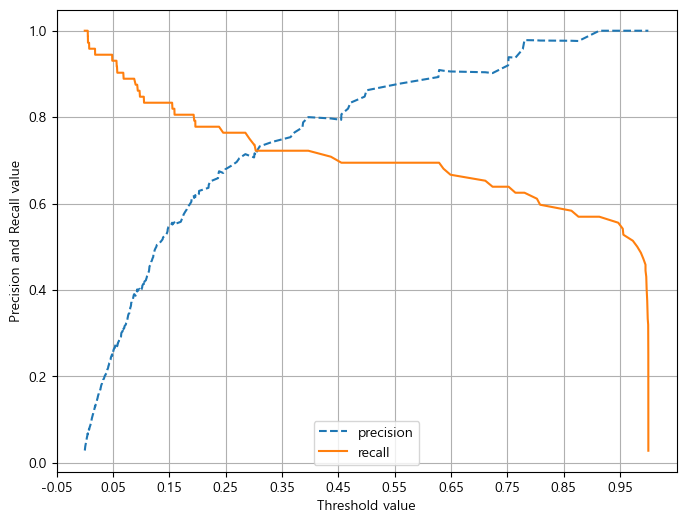

In [19]:
precision_recall_curve_plot(test_y,pred_prob)

In [24]:
get_eval_by_threshold(test_y,pred_prob,[0.29])

임곗값: 0.29
##############
 [[2455   22]
 [  18   54]] ############
 acc_score: 0.9843075715967046
 f1_score: 0.7297297297297298 
 precision: 0.7105263157894737 
 recall: 0.75


Text(51.722222222222214, 0.5, 'Actual')

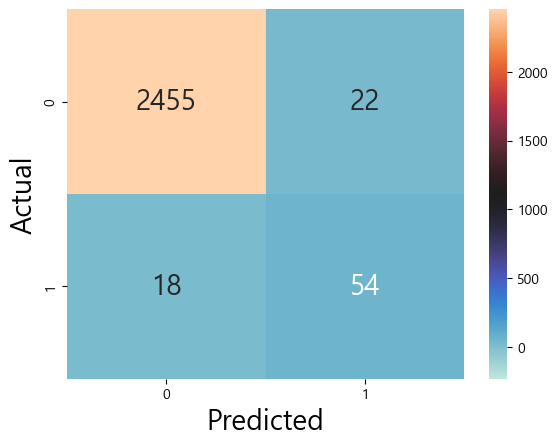

In [25]:
binarizer = Binarizer(threshold=0.29).fit(pred_prob) 
custom_rf = binarizer.transform(pred_prob)
cm = confusion_matrix(test_y, custom_rf)
sns.heatmap(cm, annot=True, annot_kws={"size": 20}, cmap="icefire", fmt='g',vmin=-230)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)

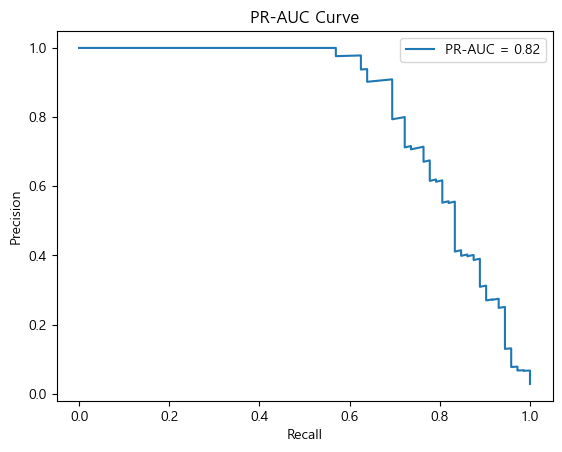

0.8230519854631924

In [26]:
plot_pr_auc_curve(test_y,pred_prob)
get_pr_auc_score(test_y,pred_prob)

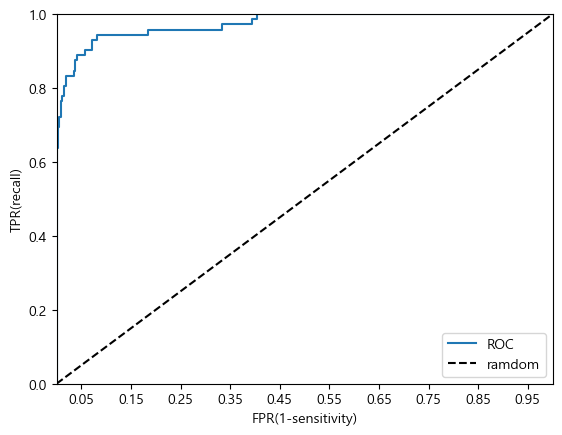

auc 값: 0.974


In [27]:
## roc 커브 auc 값
roc_curve_plot(test_y,pred_prob)
auc_score = roc_auc_score(test_y,pred_prob)
print(f'auc 값: {np.round(auc_score,4)}')

## LDA

In [28]:
proi = train_y.value_counts(property)

In [29]:
lda = LinearDiscriminantAnalysis()
param = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': [None,'auto'],
    'priors': [[proi[0],proi[1]],None]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
grid_lda = GridSearchCV(lda, param_grid=param, scoring='f1', cv=cv, n_jobs=-1, refit=True)
grid_lda.fit(train_x, train_y)

scores_df = pd.DataFrame(grid_lda.cv_results_)
scores_df.loc[:, 'param_solver':'mean_test_score']


c:\Users\msi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\msi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\msi\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py", line 615, in fit
    raise NotImplementedError("shrinkage not supported with 'svd' solver.")
NotImplementedError: shrinkage not supported with 'svd' solver.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
c:\Users\msi

,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score
0,svd,"{'priors': [0.9634146341463414, 0.036585365853...",0.641509,0.541667,0.640000,0.488889,0.588235,0.580060
1,lsqr,"{'priors': [0.9634146341463414, 0.036585365853...",0.641509,0.541667,0.640000,0.488889,0.588235,0.580060
2,eigen,"{'priors': [0.9634146341463414, 0.036585365853...",0.641509,0.541667,0.640000,0.488889,0.588235,0.580060
3,svd,"{'priors': [0.9634146341463414, 0.036585365853...",NaN,NaN,NaN,NaN,NaN,NaN
4,lsqr,"{'priors': [0.9634146341463414, 0.036585365853...",0.603774,0.588235,0.653846,0.553191,0.615385,0.602886
5,eigen,"{'priors': [0.9634146341463414, 0.036585365853...",0.603774,0.588235,0.653846,0.553191,0.615385,0.602886
6,svd,"{'priors': None, 'shrinkage': None, 'solver': ...",0.641509,0.541667,0.640000,0.488889,0.588235,0.580060
7,lsqr,"{'priors': None, 'shrinkage': None, 'solver': ...",0.641509,0.541667,0.640000,0.488889,0.588235,0.580060
8,eigen,"{'priors': None, 'shrinkage': None, 'solver': ...",0.641509,0.541667,0.640000,0.488889,0.588235,0.580060
9,svd,"{'priors': None, 'shrinkage': 'auto', 'solver'...",NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
best_lda = LinearDiscriminantAnalysis(priors=[0.9669206094627105, 0.0330793905372895], solver='lsqr',shrinkage= 'auto')
best_lda.fit(train_x,train_y)
pd.DataFrame(data=best_lda.coef_,columns=best_lda.feature_names_in_)

In [40]:
print(grid_lda.best_params_)
pred = grid_lda.predict(test_x)
pred_prob = grid_lda.predict_proba(test_x)[:,1].reshape(-1,1)
eval(pred=pred,test=test_y)

{'priors': [0.9634146341463414, 0.036585365853658534], 'shrinkage': 'auto', 'solver': 'lsqr'}
##############
 [[2453   24]
 [  21   51]] ############
 acc_score: 0.9823460180462926
 f1_score: 0.6938775510204083 
 precision: 0.68 
 recall: 0.7083333333333334


In [46]:
get_eval_by_threshold(test_y,pred_prob,[0.44])

임곗값: 0.44
##############
 [[2453   24]
 [  20   52]] ############
 acc_score: 0.982738328756375
 f1_score: 0.7027027027027027 
 precision: 0.6842105263157895 
 recall: 0.7222222222222222


Text(51.722222222222214, 0.5, 'Actual')

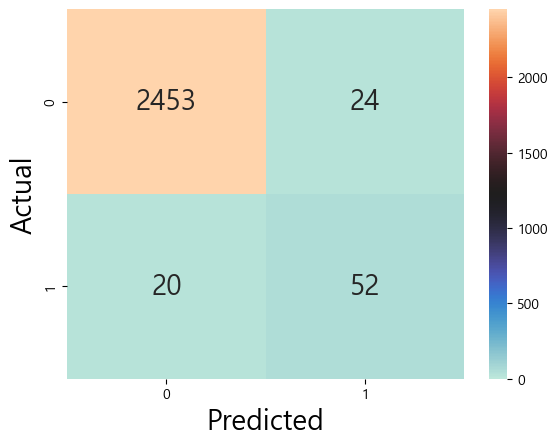

In [47]:
binarizer = Binarizer(threshold=0.44).fit(pred_prob) 
custom_rf = binarizer.transform(pred_prob)
cm = confusion_matrix(test_y, custom_rf)
sns.heatmap(cm, annot=True, annot_kws={"size": 20}, cmap="icefire", fmt='g',vmin=0)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)

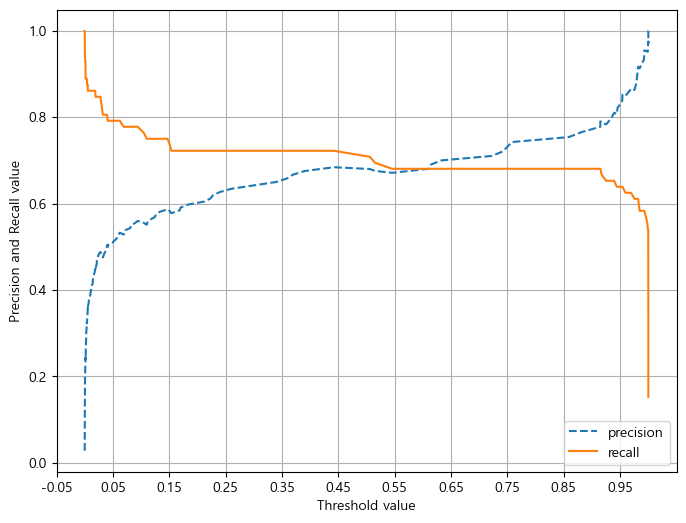

In [48]:
precision_recall_curve_plot(test_y,pred_prob)

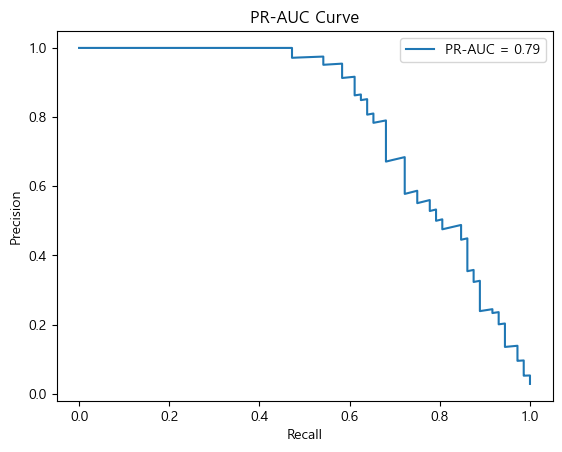

0.7903979417246417

In [49]:
plot_pr_auc_curve(test_y,pred_prob)
get_pr_auc_score(test_y,pred_prob)

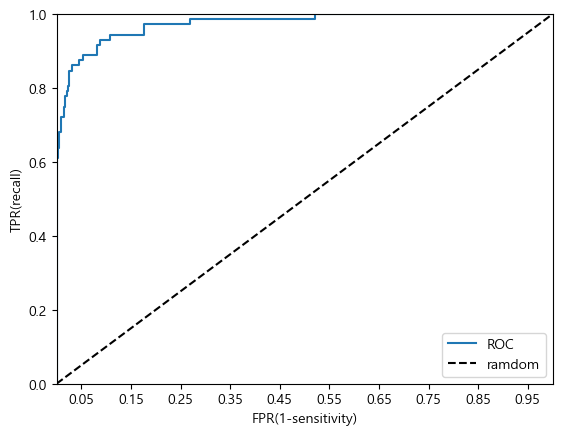

auc 값: 0.9739


In [50]:
## roc 커브 auc 값
roc_curve_plot(test_y,pred_prob)
auc_score = roc_auc_score(test_y,pred_prob)
print(f'auc 값: {np.round(auc_score,4)}')

## Gaussian_NB

In [51]:
a = train_y.value_counts(property)

In [52]:
nb=GaussianNB(priors=[a[0],a[1]])

nb.fit(train_x,train_y)

pred = nb.predict(test_x)
pred_prob = nb.predict_proba(test_x)[:,1].reshape(-1,1)
eval(pred=pred,test=test_y)

##############
 [[2383   94]
 [  12   60]] ############
 acc_score: 0.9584150647312671
 f1_score: 0.5309734513274337 
 precision: 0.38961038961038963 
 recall: 0.8333333333333334


In [53]:
get_eval_by_threshold(test_y,pred_prob,[0.9999999999999999])

임곗값: 0.9999999999999999
##############
 [[2457   20]
 [  26   46]] ############
 acc_score: 0.9819537073362102
 f1_score: 0.6666666666666666 
 precision: 0.696969696969697 
 recall: 0.6388888888888888


Text(51.722222222222214, 0.5, 'Actual')

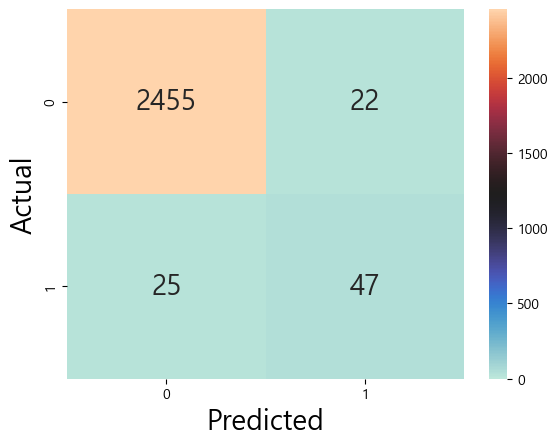

In [54]:
binarizer = Binarizer(threshold=0.9999999999999).fit(pred_prob) 
custom_rf = binarizer.transform(pred_prob)
cm = confusion_matrix(test_y, custom_rf)
sns.heatmap(cm, annot=True, annot_kws={"size": 20}, cmap="icefire", fmt='g',vmin=0)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)

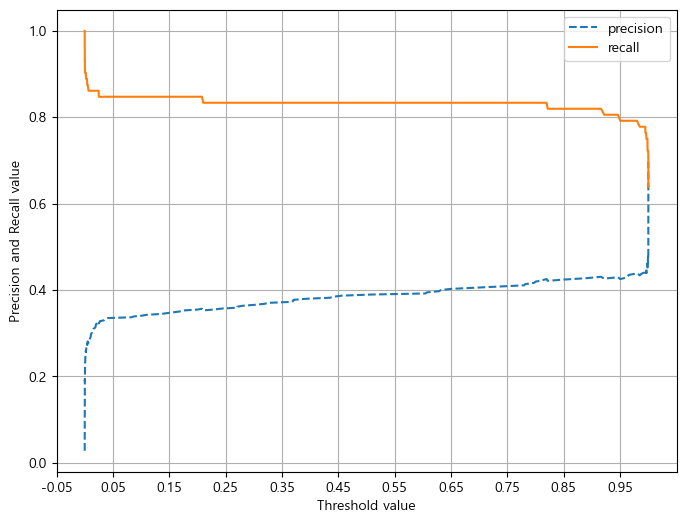

In [55]:
precision_recall_curve_plot(test_y , pred_prob)

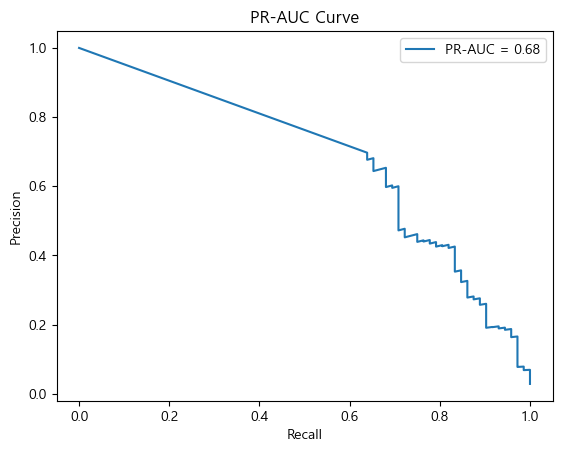

0.6771610316594406

In [56]:
plot_pr_auc_curve(test_y,pred_prob)
get_pr_auc_score(test_y,pred_prob)

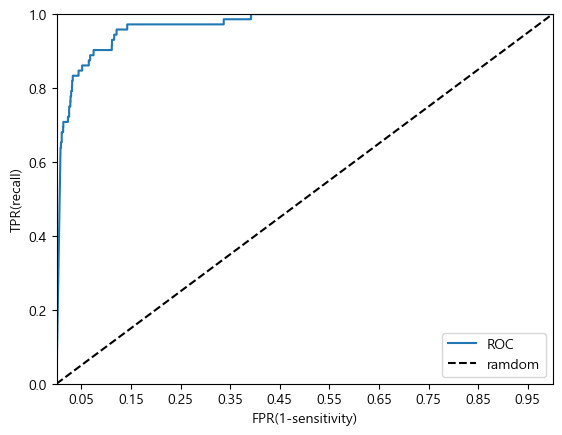

auc 값: 0.9704


In [57]:
## roc 커브 auc 값
roc_curve_plot(test_y,pred_prob)
auc_score = roc_auc_score(test_y,pred_prob)
print(f'auc 값: {np.round(auc_score,4)}')

## RandomForest

In [58]:
rf=RandomForestClassifier(random_state=1,n_jobs=-1,)
param = {
    'class_weight' :[None,'balanced'],
    'n_estimators': [50, 100],
    'max_depth': [10,15,20,25,30],
    'min_samples_split': [ 5,7, 10],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
grid_rf = GridSearchCV(rf,n_jobs=-1,scoring='f1',cv=cv,param_grid=param,refit=True)
grid_rf.fit(train_x,train_y)

scores_df = pd.DataFrame(grid_rf.cv_results_)
scores_df[scores_df['rank_test_score']==1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.654613,0.013135,0.132438,0.095978,None,10,sqrt,1,5,50,"{'class_weight': None, 'max_depth': 10, 'max_f...",0.727273,0.690909,0.740741,0.521739,0.705882,0.677309,0.079653,1


In [61]:
print(grid_rf.best_params_)
pred = grid_rf.predict(test_x)
pred_prob = grid_rf.predict_proba(test_x)[:,1].reshape(-1,1)
eval(pred=pred,test=test_y)

{'class_weight': None, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
##############
 [[2468    9]
 [  23   49]] ############
 acc_score: 0.9874460572773637
 f1_score: 0.7538461538461538 
 precision: 0.8448275862068966 
 recall: 0.6805555555555556


In [74]:
get_eval_by_threshold(test_y,pred_prob,[0.30])

임곗값: 0.3
##############
 [[2454   23]
 [  18   54]] ############
 acc_score: 0.9839152608866222
 f1_score: 0.7248322147651006 
 precision: 0.7012987012987013 
 recall: 0.75


Text(51.722222222222214, 0.5, 'Actual')

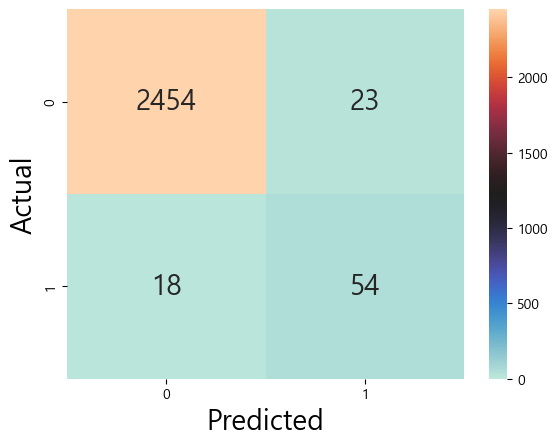

In [75]:
binarizer = Binarizer(threshold=0.30).fit(pred_prob) 
custom_rf = binarizer.transform(pred_prob)
cm = confusion_matrix(test_y, custom_rf)
sns.heatmap(cm, annot=True, annot_kws={"size": 20}, cmap="icefire", fmt='g',vmin=0)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)

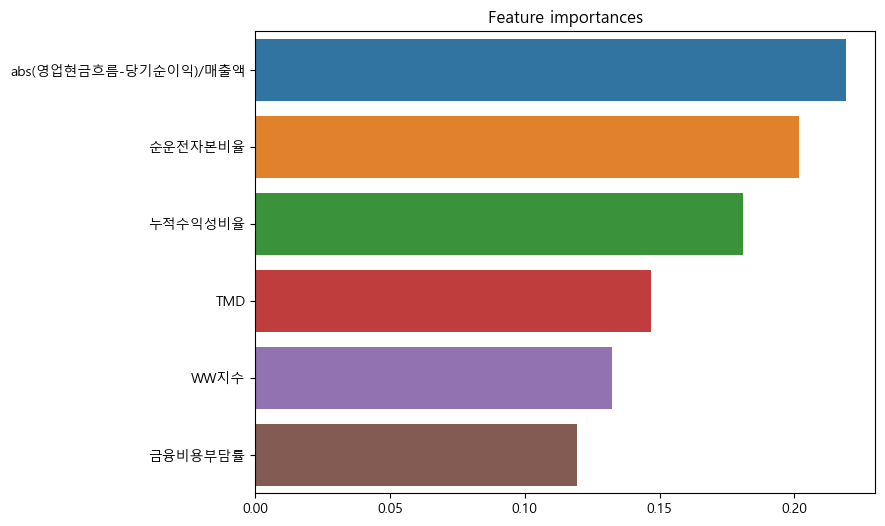

In [62]:
best_rf =RandomForestClassifier(random_state=1,class_weight=None, max_depth=10, min_samples_leaf= 1, min_samples_split= 5, n_estimators= 50)
best_rf.fit(train_x,train_y)
ftr_importances_values = best_rf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=grid_rf.feature_names_in_)
ftr_top = ftr_importances.sort_values(ascending=False)[:]

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = "Malgun Gothic"
plt.figure(figsize=(8,6))
plt.title('Feature importances')
sns.barplot(x=ftr_top , y = ftr_top.index)
plt.show()

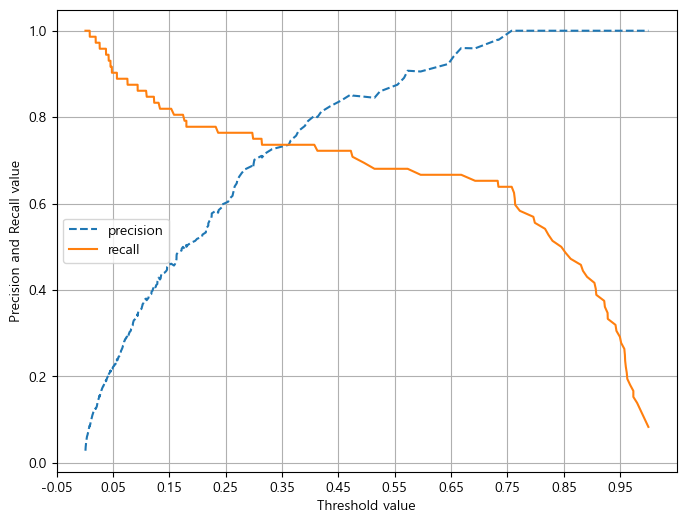

In [63]:
precision_recall_curve_plot(test_y,pred_prob)

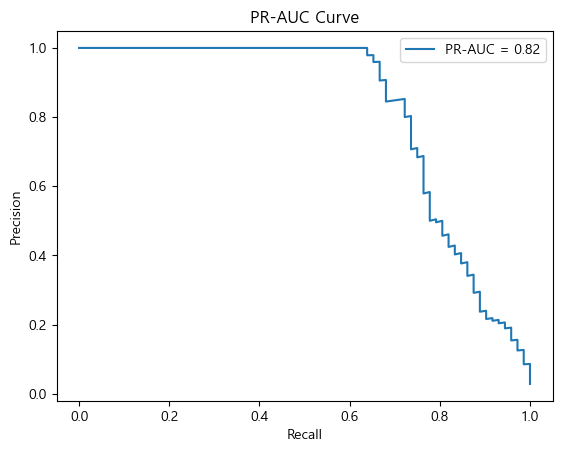

0.8180714863114353

In [76]:
plot_pr_auc_curve(test_y,pred_prob)
get_pr_auc_score(test_y,pred_prob)

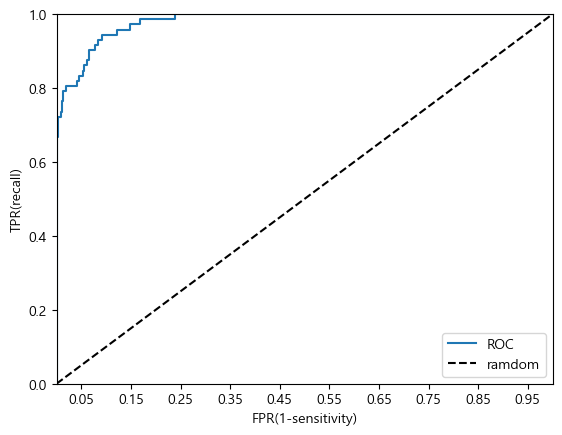

auc 값: 0.9804


In [750]:
## roc 커브 auc 값
roc_curve_plot(test_y,pred_prob)
auc_score = roc_auc_score(test_y,pred_prob)
print(f'auc 값: {np.round(auc_score,4)}')

----------------------------------------------------------
### xgboost

In [77]:
xgb = XGBClassifier(random_state=1, n_jobs=-1)
param = {
    'class_weight': ['balanced_subsample', 'balanced',None],
    'n_estimators': [50,100],
    'max_depth': [ 10,15,20,25],
    'min_child_weight': [1, 3],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'learning_rate': [0.1, 0.01, 0.001],
    'gamma': [0]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
grid_xgb = GridSearchCV(xgb, n_jobs=-1, scoring='f1', cv=cv, param_grid=param, refit=True)
grid_xgb.fit(train_x, train_y)

scores_df = pd.DataFrame(grid_xgb.cv_results_)
print(scores_df.iloc[:, 4:])


[11:05:20] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

     param_class_weight param_colsample_bytree param_gamma  \
0    balanced_subsample                    0.7           0   
1    balanced_subsample                    0.7           0   
2    balanced_subsample                    0.7           0   
3    balanced_subsample                    0.7           0   
4    balanced_subsample                    0.7           0   
..                  ...                    ...         ...   
859                None                    0.9           0   
860                None                    0.9           0   
861                None                    0.9           0   
862                None                    0.9           0   
863                None                    0.9           0   

    param_learning_rate param_max_depth param_min_chi

In [79]:
print(grid_xgb.best_params_)
pred = grid_xgb.predict(test_x)
pred_prob = grid_xgb.predict_proba(test_x)[:,1].reshape(-1,1)
eval(pred=pred,test=test_y)

{'class_weight': 'balanced_subsample', 'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 15, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
##############
 [[2468    9]
 [  21   51]] ############
 acc_score: 0.9882306786975285
 f1_score: 0.7727272727272727 
 precision: 0.85 
 recall: 0.7083333333333334


[11:06:10] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



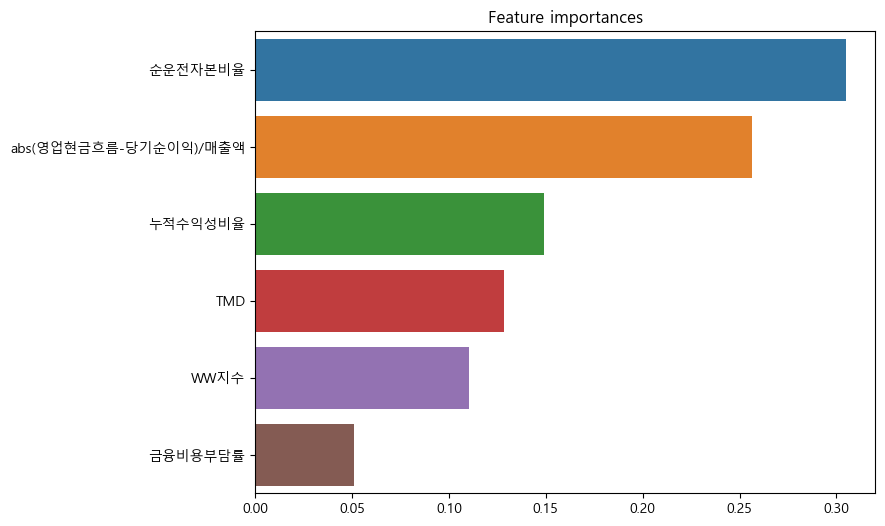

In [80]:
best_xgb =XGBClassifier(random_state=1,class_weight='balanced_subsample', colsample_bytree= 0.9, gamma= 0, learning_rate= 0.001, max_depth=15, min_child_weight= 1, n_estimators= 100, subsample= 0.9)
best_xgb.fit(train_x,train_y)
ftr_importances_values = best_xgb.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=grid_xgb.feature_names_in_)
ftr_top = ftr_importances.sort_values(ascending=False)[:]

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = "Malgun Gothic"
plt.figure(figsize=(8,6))
plt.title('Feature importances')
sns.barplot(x=ftr_top , y = ftr_top.index)
plt.show()

In [85]:
get_eval_by_threshold(test_y,pred_prob,[0.41])

임곗값: 0.41
##############
 [[2456   21]
 [  20   52]] ############
 acc_score: 0.9839152608866222
 f1_score: 0.7172413793103448 
 precision: 0.7123287671232876 
 recall: 0.7222222222222222


Text(51.722222222222214, 0.5, 'Actual')

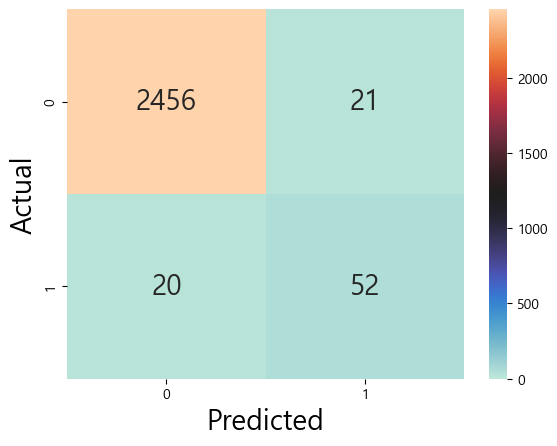

In [86]:
binarizer = Binarizer(threshold=0.41).fit(pred_prob) 
custom_rf = binarizer.transform(pred_prob)
cm = confusion_matrix(test_y, custom_rf)
sns.heatmap(cm, annot=True, annot_kws={"size": 20}, cmap="icefire", fmt='g',vmin=0)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)

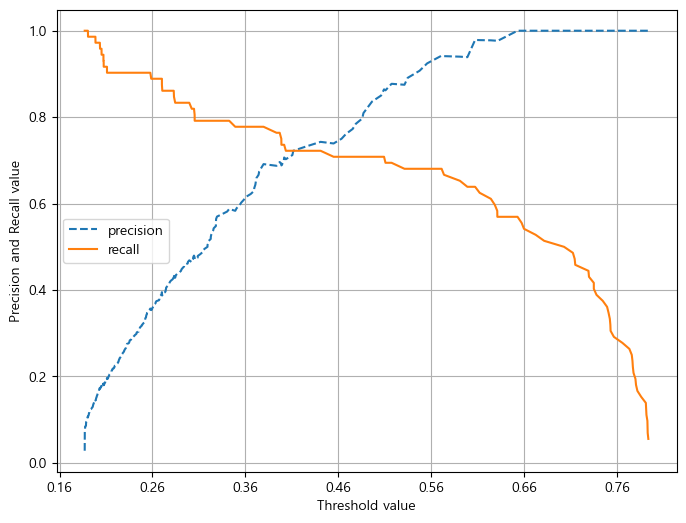

In [87]:
precision_recall_curve_plot(test_y,pred_prob)

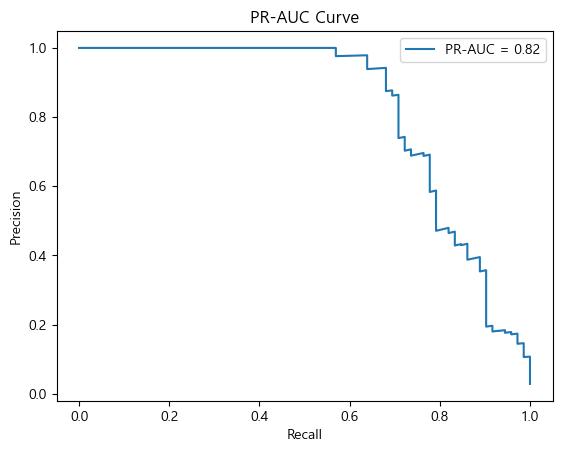

0.8212751037260502

In [88]:
plot_pr_auc_curve(test_y,pred_prob)
get_pr_auc_score(test_y,pred_prob)

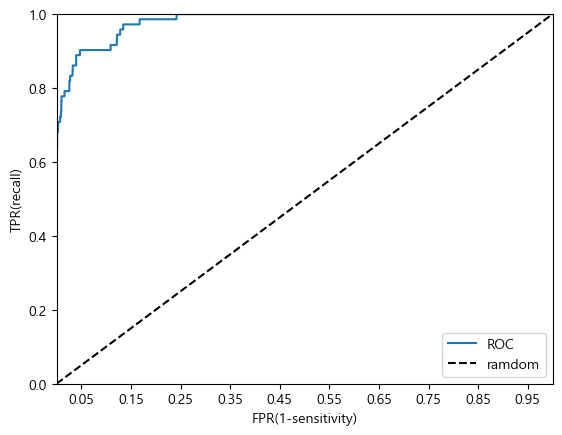

auc 값: 0.981


In [89]:
## roc 커브 auc 값
roc_curve_plot(test_y,pred_prob)
auc_score = roc_auc_score(test_y,pred_prob)
print(f'auc 값: {np.round(auc_score,4)}')

---------------
# 임계값 조정안하고 하이퍼파라미터만 조정

In [91]:
model_basic(train_x,train_y,test_x,test_y)

c:\Users\msi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[[2470    7]
 [  22   50]]
[[2453   24]
 [  22   50]]
[[2384   93]
 [  12   60]]
[[2468    9]
 [  23   49]]
[11:08:40] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[[2467   10]
 [  22   50]]


,model,acc_train,auc_train,acc_test,precision,recall,f1_score,AUC_test
0,"LogisticRegression(C=0.5, l1_ratio=0.5, random...",0.98,0.75,0.99,0.88,0.69,0.78,0.85
1,LinearDiscriminantAnalysis(priors=[0.966920609...,0.98,0.74,0.98,0.68,0.69,0.68,0.84
2,"GaussianNB(priors=[0.9669206094627105, 0.03307...",0.96,0.80,0.96,0.39,0.83,0.53,0.90
3,"(DecisionTreeClassifier(max_depth=10, max_feat...",0.99,0.82,0.99,0.84,0.68,0.75,0.84
4,"XGBClassifier(base_score=None, booster=None, c...",0.99,0.81,0.99,0.83,0.69,0.76,0.85
